<a href="https://colab.research.google.com/github/ankit-rathi/Tradevesting_v2/blob/main/mySector_Indices_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import datetime
import pytz
tz_NY = pytz.timezone('Asia/Kolkata')
datetime_NY = datetime.datetime.now(tz_NY)
print("Run date time (IST):", datetime_NY.strftime("%Y-%m-%d %H:%M:%S"))

gen_output = 0

Run date time (IST): 2024-12-26 22:07:02


In [2]:
# install libraries
!pip install yfinance
!pip install pandas-ta
#!pip install talib-binary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=67721504a48c652c9b49c25e37d29ab5fa6ad6a5cae1d333175f9f4393b1fd80
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas-ta


In [3]:
# import libraries

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
import pandas_datareader.data as web
import yfinance as yfin
import pandas_ta as ta

from google.colab import data_table

In [4]:
# set start and end date
start_date = (datetime.date.today() + datetime.timedelta(days=-366)).strftime('%Y-%m-%d')
end_date = (datetime.date.today() + datetime.timedelta(days=-1)).strftime('%Y-%m-%d')

In [5]:
# fetch nse indices scrips

import pandas as pd
import numpy as np

df_nse_sectors = pd.read_csv('https://raw.githubusercontent.com/ankit-rathi/Tradevesting/main/data/NSE_Sectors_Indices.csv')

In [6]:
sectors = df_nse_sectors['Sector'].unique()
#print(sectors)
#sectors = ['BANKS', 'IT']
df_sectors = pd.DataFrame()
for sector in sectors:
  stocks = df_nse_sectors[df_nse_sectors['Sector'] == sector]['Symbol'].values
  df_sector = pd.DataFrame()
  tweight = 0
  for stock in stocks:
    stock_df = yfin.Ticker(stock+'.NS').history(period='max', interval='1d')[map(str.title, ['open', 'close', 'low', 'high', 'volume'])]
    col = ['Close']
    stock_df = stock_df[col]
    stock_df['Split'] = 1
    weight = df_nse_sectors[df_nse_sectors['Symbol'] == stock]['Weight'].values[0]
    tweight = sum(df_nse_sectors[df_nse_sectors['Sector'] == sector]['Weight'].values)
    if stock == 'NESTLEIND':
      stock_df.loc[stock_df.index < '2024-01-01', 'Split'] = 10
    #stock_df[stock] = (stock_df[col]*weight)/(tweight*stock_df['Split'].values[0])
    stock_df[stock] = stock_df['Close']/stock_df['Split']
    col = [stock]
    stock_df = stock_df[col]
    df_sector = pd.concat([df_sector, stock_df], axis=1)

  df_sector[sector] = df_sector[stocks].sum(axis=1)
  col = [sector]
  df_sector = df_sector[col]
  df_sectors = pd.concat([df_sectors, df_sector], axis=1)
sector_df_full = df_sectors

In [7]:
def stock_prec_dev(stock_symbol):
    #print(stock_symbol)
    #stock_symbol = 'ULTRACEMCO.NS'
    short_window = 20
    mid_window = 50
    long_window = 200
    moving_avg = 'SMA'

    # import the closing price data of the stock for the aforementioned period of time in Pandas dataframe
    start = datetime.datetime(*map(int, start_date.split('-')))
    end = datetime.datetime(*map(int, end_date.split('-')))

    stock_df = df_sectors[[stock_symbol]]
    stock_df.columns = ['Close']

    #stock_df['Max'] = round(max(stock_df['Close']),2)
    stock_df['Max']  = round(stock_df['Close'].dropna().max(), 2)
    stock_df = stock_df[(stock_df.index <= end_date) & (stock_df.index >= start_date)]
    stock_df['200_SMA'] = round(stock_df['Close'].rolling(window = 200, min_periods = 1).mean(),0)
    stock_df['Dev%_200'] = round((stock_df['Close'] - stock_df['200_SMA'])*100/stock_df['200_SMA'],2)
    stock_df.dropna(axis = 0, inplace = True) # remove any null rows

    stock_df['Sector'] = stock_symbol

    stock_df['Close'] = round(stock_df['Close'],2)

    #stock_df['Min'] = round(min(stock_df['Close']),2)
    stock_df['Min']  = round(stock_df['Close'].dropna().min(), 2)
    #stock_df['Gained%'] = round((stock_df['Close'] - stock_df['Min'])*100/stock_df['Min'],2)
    stock_df.ta.rsi(append=True)
    #stock_df.rename(columns={'RSI_14':'RSI'}, inplace=True)
    #stock_df['Close'] = round(stock_df['Close'],0)
    stock_df['RSI_14'] = round(stock_df['RSI_14'],0)
    stock_df['ATH%'] = round((stock_df['Max'] - stock_df['Close'])*100/stock_df['Close'],2)
    #stock_df['Sector'] = stock_symbol
    stock_df = stock_df.tail(1)
    return stock_df

In [8]:
df_final =  pd.DataFrame()
for sector in sectors:

  df_tmp = stock_prec_dev(sector)
  df_final = pd.concat([df_final, df_tmp], ignore_index = True) #df_final.append(df_tmp)
# all sectors
df_final = df_final.sort_values(by = 'ATH%', ascending=False)
#data_table.DataTable(df_final, include_index=False)
df_final

,Close,Max,200_SMA,Dev%_200,Sector,Min,RSI_14,ATH%
0,29865.70,39245.70,32922.0,-9.28,AUTO,24915.69,30.0,31.41
4,11259.40,14389.95,12526.0,-10.11,FMCG,9913.14,35.0,27.80
7,5466.93,6896.25,6097.0,-10.33,METAL,5222.12,37.0,26.14
14,4118.15,4911.95,4262.0,-3.38,FOOTWEAR,3882.30,42.0,19.28
6,3261.16,3818.51,3244.0,0.53,MEDIA,1870.27,43.0,17.09
13,6646.76,7751.67,6332.0,4.97,TEXTILES,5348.15,46.0,16.62
9,21255.49,24677.85,22291.0,-4.65,CHEMICAL,18708.05,37.0,16.10
2,9783.91,11328.00,10105.0,-3.18,FINANCE,9164.02,41.0,15.78
12,4587.96,5184.93,4631.0,-0.93,JEWELLERY,4148.98,45.0,13.01
3,15721.40,17263.20,14691.0,7.01,IT,12359.88,36.0,9.81


<Axes: xlabel='Date'>

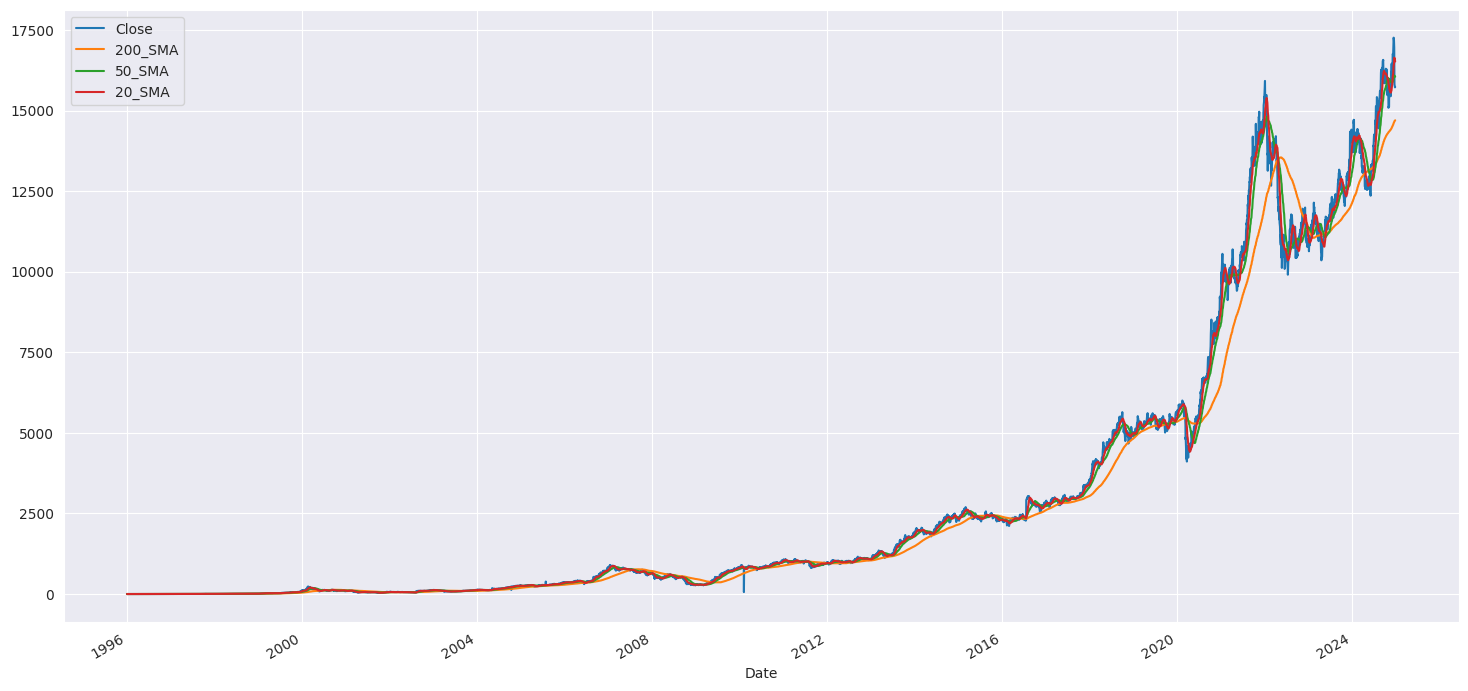

In [9]:
col = ['IT']
sector_df = sector_df_full[col]
sector_df.columns = ['Close']
sector_df['200_SMA'] = round(sector_df['Close'].rolling(window = 200, min_periods = 1).mean(),0)
sector_df['50_SMA'] = round(sector_df['Close'].rolling(window = 50, min_periods = 1).mean(),0)
sector_df['20_SMA'] = round(sector_df['Close'].rolling(window = 20, min_periods = 1).mean(),0)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')
tmp_df = sector_df.reset_index()
tmp_df.plot(x='Date', y=['Close','200_SMA','50_SMA','20_SMA'], figsize=(18,9))

In [10]:
df_sectors = df_sectors[(df_sectors.index <= end_date) & (df_sectors.index >= start_date)]
for sector in sectors:
  base_value = df_sectors[sector].head(1).values[0]
  df_sectors[sector] = df_sectors[sector]*100/base_value

df_sectors

,AUTO,BANKS,FINANCE,IT,FMCG,PHARMA,MEDIA,METAL,INFRA,CHEMICAL,CEMENT,DURABLES,JEWELLERY,TEXTILES,FOOTWEAR,SUGAR
Date,,,,,,,,,,,,,,,,
2023-12-26 00:00:00+05:30,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2023-12-27 00:00:00+05:30,101.291792,101.048588,100.783559,100.540011,100.207911,100.243866,100.417079,100.640475,102.286058,99.370165,101.385864,100.365992,100.820075,100.815189,100.362625,100.735885
2023-12-28 00:00:00+05:30,101.827531,101.509608,101.151955,100.233939,101.378105,101.723106,100.088222,100.423448,102.631078,99.845292,101.193288,100.248859,101.205914,100.462126,99.591939,102.152900
2023-12-29 00:00:00+05:30,102.360778,100.977765,101.921866,100.215206,102.709037,101.407804,100.267691,101.411161,102.682315,100.774246,101.563141,101.264247,100.581714,100.734164,100.652090,101.789031
2024-01-01 00:00:00+05:30,101.731556,100.778473,101.803832,100.472668,127.198687,101.398939,100.585054,102.453898,102.733267,101.628292,101.334838,100.982651,100.980257,100.966645,99.832016,102.424340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-18 00:00:00+05:30,122.953846,109.806961,103.247325,118.283141,114.425935,142.702245,95.017333,104.200801,120.293869,111.306735,102.215716,233.797124,99.265331,126.278988,91.340200,154.482061
2024-12-19 00:00:00+05:30,122.666876,108.510598,100.981989,114.704903,114.067321,144.666497,94.477339,102.764202,119.824793,110.406552,101.200210,232.095191,97.651301,125.054439,91.283741,154.574892
2024-12-20 00:00:00+05:30,120.607933,106.960721,99.501877,110.374177,112.599572,144.148251,91.975226,100.505493,117.787394,109.287265,99.080520,228.925120,96.957553,120.125434,90.213224,149.029891


In [11]:
cols = df_sectors.columns
for col in cols:
  median = df_sectors.loc[df_sectors[col]< 90, col].median()
  df_sectors.loc[df_sectors[col] < 90, col] = np.nan
  df_sectors[col] = np.where(df_sectors[col] < 90, median,df_sectors[col])

<Axes: xlabel='Date'>

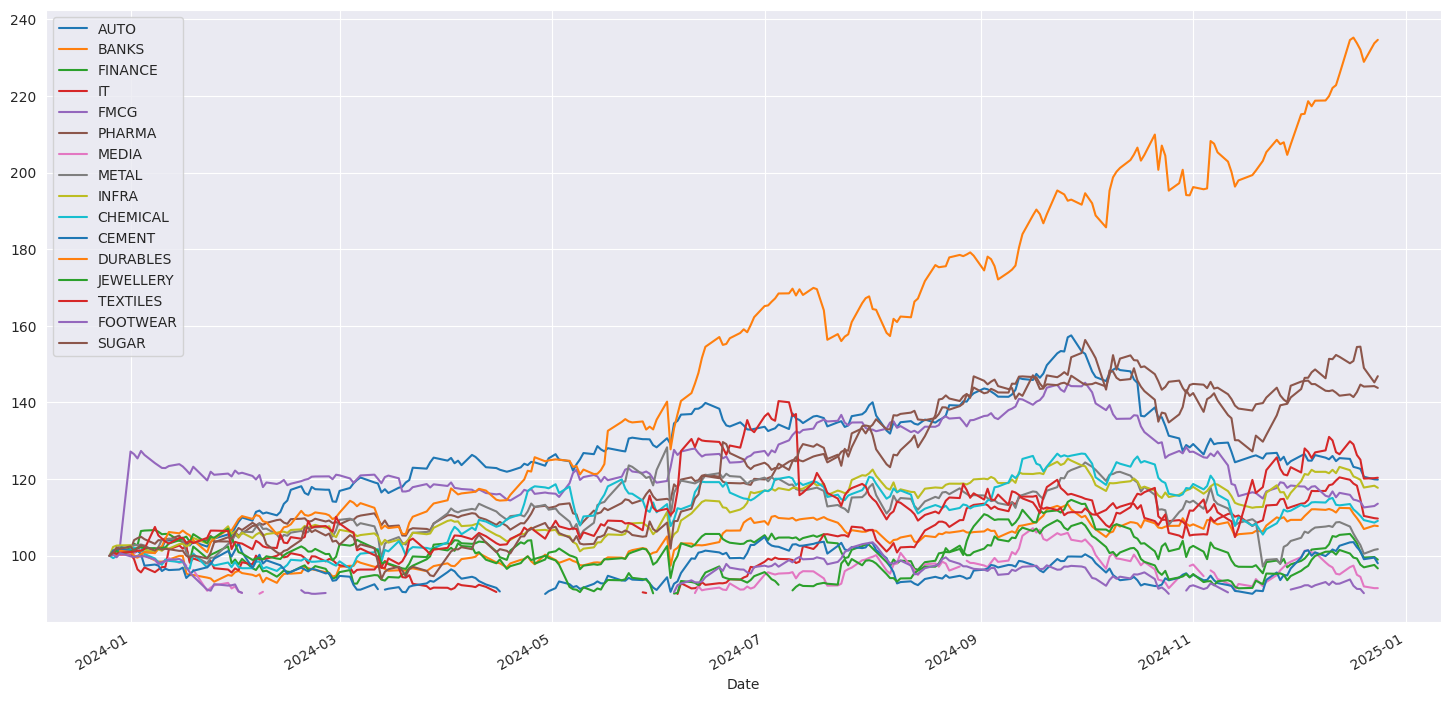

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid')
tmp_df = df_sectors.reset_index()
tmp_df.plot(x='Date', y=sectors, figsize=(18,9))

In [13]:
df_tmp = df_sectors.tail(1).T
df_tmp.columns = ['Close']
df_tmp.sort_values(by = 'Close', ascending=False)

,Close
DURABLES,234.676840
SUGAR,146.863023
PHARMA,143.803725
TEXTILES,120.350858
AUTO,119.867032
INFRA,117.729720
FMCG,113.580595
IT,109.690767
CHEMICAL,109.093000
BANKS,107.729262
